# Fake Data Detector



## Set up

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import base64
import json
import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform
from oauth2client.client import GoogleCredentials

from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Building the model

We'll create an AI generated text detector model using the dataset from here: https://www.kaggle.com/datasets/starblasters8/human-vs-llm-text-corpus 


In [3]:
%matplotlib inline

In [5]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT + "-genai"
FILE_DIR = f"gs://{BUCKET}/data"
REGION = "us-central1"

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

BATCH_SIZE = 32

In [19]:
DATASET_NAME = "final_dataset_1k.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ["text", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,text,source
0,The Philosophy and Ethics of Transhumanism\n\n...,AI
1,Crime-tracking app Citizen is launching its ow...,AI
2,The court in Novorossiysk gave two of the danc...,AI
3,"then drops the drumsticks, poses, then walks o...",AI
4,On tally went to the beach. She found a sand d...,AI


In [8]:
CLASSES = {"Human": 0, "AI": 1}
N_CLASSES = len(CLASSES)

In [9]:

def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [10]:
encode_labels(titles_df.source[:4])

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [17]:
DATASET_SIZE = titles_df.shape[0]
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.text[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.text[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

To be on the safe side, we verify that the train and test splits have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure the performance of our models.

In [18]:
sources_train.value_counts()

source
Human    409
AI       367
Name: count, dtype: int64

In [19]:
sources_valid.value_counts()

source
Human    121
AI        74
Name: count, dtype: int64

Using encode_labels function, we can now prepare the training and validation data to feed our models. The labels will be one-hot-encoded 3D vectors.

In [20]:
Y_train = encode_labels(sources_train)
Y_valid = encode_labels(sources_valid)

In [7]:
Y_train[:3]

NameError: name 'Y_train' is not defined

## Keras Text Preprocessing Layer

Before we start passing data to the model, we need to preprocess the text. Using Keras preprocessing layers we can now include this in the model directly.

The preprocessing that we will be doing:
- Tokenizing the text
- Integerizing the tokens

At instanciation, we can specify the maximum length of the sequence output as well as the maximum number of tokens to be considered

In [46]:
MAX_LEN = 20000
MAX_TOKENS = 2000000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, max_tokens=MAX_TOKENS
)

Before using this layer in our model, we need to adapt it to our data so that it generates a token-to-integer mapping. Remeber our dataset looks like the following:



In [47]:
titles_df.head()

,text,source
0,The Philosophy and Ethics of Transhumanism\n\n...,AI
1,Crime-tracking app Citizen is launching its ow...,AI
2,The court in Novorossiysk gave two of the danc...,AI
3,"then drops the drumsticks, poses, then walks o...",AI
4,On tally went to the beach. She found a sand d...,AI


We can directly use the Pandas Series corresponding to the titles in our dataset to adapt the data using the adapt method:

In [48]:
preprocessing_layer.adapt(titles_df.text)

Now, the preprocessing layer can create the integer representation of our input text if we simply apply the layer to it:

In [49]:
X_train, X_valid = titles_train, titles_valid
X_train[:5]

0    The Philosophy and Ethics of Transhumanism\n\n...
1    Crime-tracking app Citizen is launching its ow...
2    The court in Novorossiysk gave two of the danc...
3    then drops the drumsticks, poses, then walks o...
4    On tally went to the beach. She found a sand d...
Name: text, dtype: object

In [50]:
integers = preprocessing_layer(X_train[:5])
integers

<tf.Tensor: shape=(5, 20000), dtype=int64, numpy=
array([[    2,   803,     4, ...,     0,     0,     0],
       [27069,  6439,  3765, ...,     0,     0,     0],
       [    2,  1299,     6, ...,     0,     0,     0],
       [  176, 10004,     2, ...,     0,     0,     0],
       [   17, 19220,   752, ...,     0,     0,     0]])>

In [52]:
preprocessing_layer(['Ghi is awesome!'])

<tf.Tensor: shape=(1, 20000), dtype=int64, numpy=array([[    1,     9, 10298, ...,     0,     0,     0]])>

We will need the VOCAB_SIZE when creating the embedding layer in the model. We can get it using this function

In [53]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

30166

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [54]:
def build_dnn_model(embed_dim):
    model = Sequential(
        [
            Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]
            ),  # TODO 3
            Lambda(lambda x: tf.reduce_mean(x, axis=1)),  # TODO 4
            Dense(N_CLASSES, activation="softmax"),  # TODO 5
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Below we train the model on 100 epochs but adding an EarlyStopping callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by PATIENCE . Note that we also give the model.fit method a Tensorboard callback so that we can later compare all the models using TensorBoard.

Epoch 1/100
3/3 [==============================] - 2s 463ms/step - loss: 0.6926 - accuracy: 0.5271 - val_loss: 0.6869 - val_accuracy: 0.6205
Epoch 2/100
3/3 [==============================] - 1s 439ms/step - loss: 0.6922 - accuracy: 0.5271 - val_loss: 0.6864 - val_accuracy: 0.6205
Epoch 3/100
3/3 [==============================] - 2s 635ms/step - loss: 0.6921 - accuracy: 0.5271 - val_loss: 0.6858 - val_accuracy: 0.6205
Epoch 4/100
3/3 [==============================] - 1s 386ms/step - loss: 0.6920 - accuracy: 0.5271 - val_loss: 0.6856 - val_accuracy: 0.6205
Epoch 5/100
3/3 [==============================] - 1s 379ms/step - loss: 0.6919 - accuracy: 0.5271 - val_loss: 0.6847 - val_accuracy: 0.6205
Epoch 6/100
3/3 [==============================] - 1s 375ms/step - loss: 0.6917 - accuracy: 0.5271 - val_loss: 0.6841 - val_accuracy: 0.6205
Epoch 7/100
3/3 [==============================] - 1s 393ms/step - loss: 0.6916 - accuracy: 0.5271 - val_loss: 0.6834 - val_accuracy: 0.6205
Epoch 8/100
3

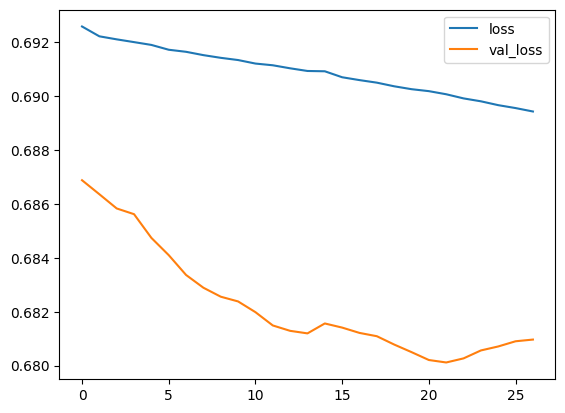

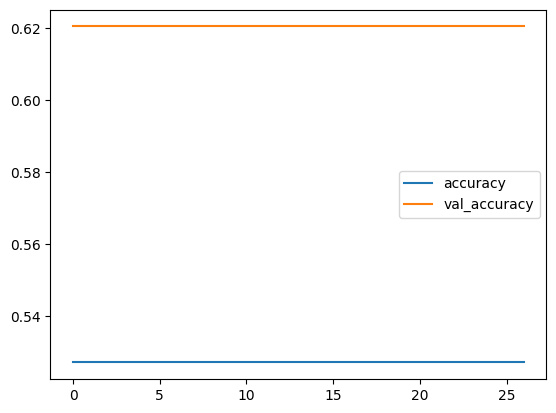

In [55]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "dnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 5

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(dnn_history.history)[["accuracy", "val_accuracy"]].plot()

dnn_model.summary()

In [56]:
"""
function to get the prediction from the model
model=trained model name
instances=list of instances to get prediction for
"""


def get_predictions(model, instances):
    prediction = model.predict(instances)
    title_prediction = list(zip(instances, prediction))
    for line, predict in title_prediction:
        print(
            "Title: {} \n Human:{:.2%} \n AI:{:.2%}".format(
                line, float(predict[0]), float(predict[1]),
            )
        )

In [57]:
X_train[:5]

0    The Philosophy and Ethics of Transhumanism\n\n...
1    Crime-tracking app Citizen is launching its ow...
2    The court in Novorossiysk gave two of the danc...
3    then drops the drumsticks, poses, then walks o...
4    On tally went to the beach. She found a sand d...
Name: text, dtype: object

In [58]:
get_predictions(dnn_model, X_train[:5])

1/1 [==============================] - 0s 485ms/step
Title: The Philosophy and Ethics of Transhumanism

Transhumanism, a concept rooted in the idea of enhancing human capabilities through the use of advanced technology, has become a topic of great interest and debate in recent years. With the rapid advancements in fields such as artificial intelligence, genetics, and nanotechnology, the possibility of transcending our biological limitations and becoming posthuman beings seems both exciting and terrifying. However, the philosophy and ethics of transhumanism raise profound questions about what it means to be human, the value of life, and the potential consequences of tampering with our very essence.

At the heart of transhumanism lies the belief that humanity can and should strive for a state of enhanced existence, one in which we can overcome the limitations imposed by our biology. This includes not only physical enhancements but also cognitive and emotional ones. Proponents of transhum

In [60]:
get_predictions(dnn_model,  pd.Series(["Ghi is awesome!"]))

1/1 [==============================] - 0s 37ms/step
Title: Ghi is awesome! 
 Human:51.99% 
 AI:48.01%


In [62]:
shutil.rmtree("export", ignore_errors=True)
os.mkdir("export")
dnn_model.save("export/text_model")

INFO:tensorflow:Assets written to: export/genai_detection_model/assets


INFO:tensorflow:Assets written to: export/genai_detection_model/assets


In [63]:
!ls export/genai_detection_model

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


## Image data

In [15]:
!pip install kagglehub

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:00<00:00, 158MB/s]  

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

TRAIN_PATH = "/home/jupyter/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train"
TEST_PATH = "/home/jupyter/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test"
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE


train_dataset = image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,  
    subset="training",
    seed=SEED,  
    image_size=IMAGE_SIZE,  
    batch_size=32
)
val_dataset = image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,  
    subset="validation",
    seed=SEED,  
    image_size=IMAGE_SIZE,  
    batch_size=8
)
test_dataset = image_dataset_from_directory(
    TEST_PATH,
    image_size=IMAGE_SIZE,  
    batch_size=8,
    shuffle=False  # No need to shuffle test data
)


# data_augmentation = keras.Sequential([
#     RandomFlip("horizontal"),
#     RandomRotation(0.1),
#     RandomZoom(0.1),
# ])

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


train = train_dataset.prefetch(buffer_size=AUTOTUNE)
val = val_dataset.prefetch(buffer_size=AUTOTUNE)
test = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Train batches: {len(train)}")
print(f"Validation batches: {len(val)}")
print(f"Test batches: {len(test)}")

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.
Train batches: 2500
Validation batches: 2500
Test batches: 2500


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models

In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  

    layers.Flatten(),  
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_best_only=True
)
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
2500/2500 [==============================] - 58s 23ms/step - loss: 0.4800 - accuracy: 0.8044 - val_loss: 0.3209 - val_accuracy: 0.8619
Epoch 2/20
2500/2500 [==============================] - 56s 23ms/step - loss: 0.3148 - accuracy: 0.8664 - val_loss: 0.3026 - val_accuracy: 0.8730
Epoch 3/20
2500/2500 [==============================] - 54s 22ms/step - loss: 0.2837 - accuracy: 0.8822 - val_loss: 0.3380 - val_accuracy: 0.8572
Epoch 4/20
2500/2500 [==============================] - 55s 22ms/step - loss: 0.2597 - accuracy: 0.8936 - val_loss: 0.2555 - val_accuracy: 0.8949
Epoch 5/20
2500/2500 [==============================] - 56s 22ms/step - loss: 0.2411 - accuracy: 0.9027 - val_loss: 0.2617 - val_accuracy: 0.9002
Epoch 6/20
2500/2500 [==============================] - 58s 23ms/step - loss: 0.2246 - accuracy: 0.9089 - val_loss: 0.2411 - val_accuracy: 0.9022
Epoch 7/20
2500/2500 [==============================] - 57s 23ms/step - loss: 0.2108 - accuracy: 0.9151 - val_loss: 0.2319 -

<Axes: >

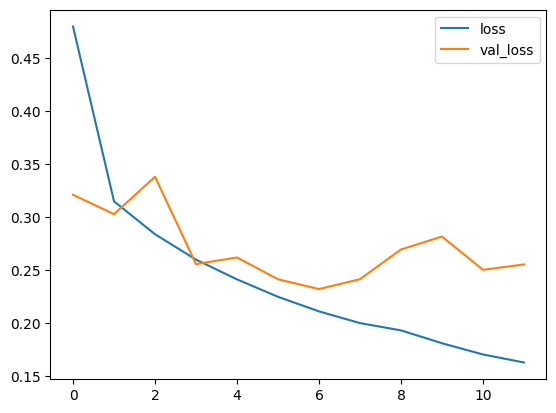

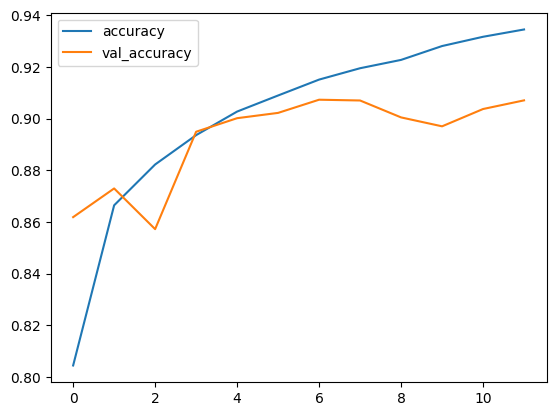

In [23]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

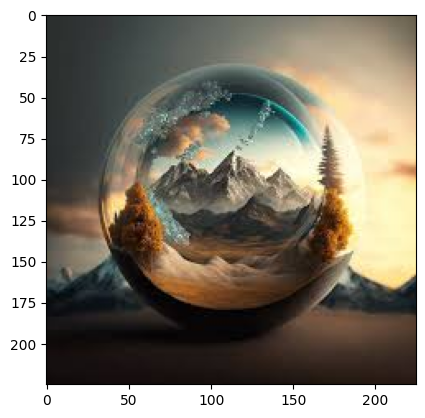

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Read Images
img = mpimg.imread('images.jpeg')
 
# Output Images
plt.imshow(img)
      

In [33]:
!pip install Image

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 71.1 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19483 sha256=b344147c4b81c596d33fc6bc48a18defc177cd9692d8e3e846d3917f3ac34f27
  Stored in directory: /home/jupyter/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built Image


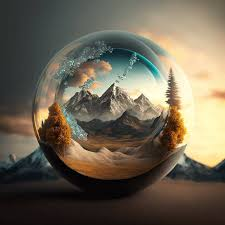

In [11]:
from PIL import Image
img = Image.open('images.jpeg')    # Open image as PIL image object
img

In [12]:
img = img.resize((32,32))

In [13]:
img_arr = np.array(img)

In [15]:
img_arr = img_arr.reshape(1,32,32,3)

In [16]:
model.predict(img_arr)

1/1 [==============================] - 0s 182ms/step


array([[0.45225456]], dtype=float32)

In [17]:
img_2 = Image.open('human.jpg')    # Open image as PIL image object
img_2 = img_2.resize((32,32))

In [18]:
img_arr_2 = np.array(img_2)
img_arr_2 = img_arr_2.reshape(1,32,32,3)

In [19]:
model.predict(img_arr_2)

1/1 [==============================] - 0s 18ms/step


array([[0.9871367]], dtype=float32)

In [9]:
#from tensorflow.keras.models import load_model

In [10]:
#model = load_model('image_model')

In [52]:
scores = model.evaluate(test)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2334 - accuracy: 0.9044


In [53]:
model.save('image_model')

INFO:tensorflow:Assets written to: image_model/assets


INFO:tensorflow:Assets written to: image_model/assets


---

## Build a streamlit application

With our image classification model prepared, let's create a Streamlit app to make it interactive and user-friendly.

### Import Libraries
First, we'll import the necessary Python libraries, including Streamlit itself, as well as any other libraries needed for image processing and model loading.

In [6]:
%%writefile app.py
"""Streamlit Fake Data Detector App"""

import numpy as np
import pandas as pd
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model

Overwriting app.py


### Add text elements
Streamlit eventually renders a web page, but we can simply use Python modules to define and configure the the web page elements.

We'll start by configuring some metadata for our app.

- [`st.set_page_config`](https://docs.streamlit.io/develop/api-reference/configuration/st.set_page_config) lets us customize aspects like the page title and favicon (the little icon that appears in your browser tab).

Streamlit provides a variety of ways to display text content:
- [`st.title`](https://docs.streamlit.io/develop/api-reference/text/st.title) is used to add a main heading to our page.
- You can also use [`st.header`](https://docs.streamlit.io/develop/api-reference/text/st.header) and [`st.subheader`](https://docs.streamlit.io/develop/api-reference/text/st.subheader) for smaller headings.
- [`st.text`](https://docs.streamlit.io/develop/api-reference/text/st.text) is for displaying plain text.
- [`st.markdown`](https://docs.streamlit.io/develop/api-reference/text/st.markdown) lets you add formatted text using Markdown syntax.
For more options, you can check the Streamlit documentation for [other text elements](https://docs.streamlit.io/develop/api-reference/text).

Streamlit also offer a "swiss-army knife" command called [`st.write`](https://docs.streamlit.io/develop/api-reference/write-magic/st.write). It can handle many types of content, including text, DataFrames (tables of data), Matplotlib plots, and even Keras machine learning models.

Also, here we define a few global variables that we'll use later.

In [7]:
%%writefile -a app.py

st.set_page_config(page_title="Fake Detector Classifier", page_icon="✨")

st.title("Fake Data Detector")

st.markdown(
    "Welcome to this simple web application that detect AI generated data"
)

IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
TEXT_PATH = "text_model"
IMAGE_PATH = "image_model"

Appending to app.py


### Defining Model Loading with Caching

We'll define a function to load our image classification model using `keras.models.load_model`.

To avoid reloading the model every time we make a prediction, we'll use the [`@st.cache_resource`](https://docs.streamlit.io/develop/api-reference/caching-and-state/st.cache_resource) decorator. This decorator caches the output of our function, making it much faster to access the model on subsequent runs.

**Note: [`@st.cache_resource`](https://docs.streamlit.io/develop/api-reference/caching-and-state/st.cache_resource) is best suited for global objects that can't be easily serialized (converted to a simple data format), such as database connections or complex machine learning models. For simpler, serializable objects (like pandas DataFrames), you might consider using [`tf.cache_data`](https://docs.streamlit.io/develop/api-reference/caching-and-state/st.cache_data) instead.**

For a deeper dive into caching and how to optimize your Streamlit apps, you can check out [this document](https://docs.streamlit.io/develop/concepts/architecture/caching).

In [8]:
%%writefile -a app.py

@st.cache_resource(show_spinner=False)
def load_and_cache_model(model_path):
    #model_path = "genai_detection_model"
    model = load_model(model_path)
    return model


Appending to app.py


In [9]:
%%writefile -a app.py

def get_predictions_text(model, text):
    instances = pd.Series([text])
    prediction = model.predict(instances)
    if prediction[0][0] > prediction[0][1]:
        pred = round(prediction[0][0],2)
        #return f"Human: {pred:.2f}
        result = f"Human. Confidence: {pred:.2f}"  
    else:
        pred = round(prediction[0][1],2)
        result = f"AI. Confidence: {pred:.2f}"
                    
    return pred

Appending to app.py


In [10]:
%%writefile -a app.py

def read_image(img_bytes):
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def get_predictions_image(model, image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    if predictions[0][0] > 0.5:
        pred = round(predictions[0][0],2)
        #return f"Human: {pred:.2f}
        result = f"Human. Confidence: {pred:.2f}"
    else:
        pred = round(1 - predictions[0][0],2)
        #return f"Human: {pred:.2f}
        result = f"AI. Confidence: {pred:.2f}"
    return result

Appending to app.py


In [11]:
%%writefile -a app.py

def main():
    text = st.text_area("Please enter the content that you want to verify:")
    class_btn = st.button("Classify text")
    st.markdown('Please upload the image that you want to verify')
    file_uploaded = st.file_uploader("Choose File", type=["png", "jpg", "jpeg"])
    class_btn = st.button("Classify image")
    if text is not None:
        st.markdown(text)
        
        if class_btn:
            with st.spinner("Model predicting...."):
                loaded_model = load_and_cache_model(TEXT_PATH)
                prediction_text = get_predictions_text(loaded_model, text)
                st.success(prediction_text)
    
   
    if file_uploaded is not None:
        
        image = read_image(file_uploaded.read())
        st.image(image.numpy(), caption="Uploaded Image", use_column_width=True)
        
        if class_btn:
            with st.spinner("Model predicting...."):
                loaded_model = load_and_cache_model(IMAGE_PATH)
                prediction_image = get_predictions_image(loaded_model, image)
                st.success(prediction_image)
    

if __name__ == "__main__":
    main()

Appending to app.py


## Deploying the App on Cloud Run
Our Streamlit application is ready! Let's deploy it to Google Cloud Run, a serverless platform designed to run containerized applications seamlessly.

### Defining Dockerfile and Dependencies
To containerize our app for Cloud Run, we define `requirements.txt` and `Dockerfile`.

In [31]:
%%writefile requirements.txt
numpy==1.23.5
streamlit==1.30.0
tensorflow==2.12.0
pandas==2.2.3

Overwriting requirements.txt


In [32]:
%%writefile Dockerfile
FROM python:3.10.14

WORKDIR /app

COPY requirements.txt /app
RUN pip install -r requirements.txt

COPY export /app
COPY app.py /app

EXPOSE 8080

CMD streamlit run --server.port 8080 --server.enableCORS false app.py

Overwriting Dockerfile


**Note: We've split the `COPY` command into multiple lines, each copying different files. Although this is not required, this is a crucial optimization for Docker's caching mechanism.<br> If you make changes only to app.py, the next time you build the image, Docker will reuse the cached layers for the dependency installation and other files, speeding up the build process significantly.**

### Building and Pushing the Container to Artifact Registry
Now that we have our `Dockerfile`, we can build the Docker image of our Streamlit app and push it to Google Cloud's Artifact Registry. 
Artifact Registry offers a secure and scalable way to store your container images.

First, we'll create a new repository in Artifact Registry to house our container image.

In [12]:
STREAMLIT_ARTIFACT_REG_REPO = "genai-classification-app-v16"
os.environ["STREAMLIT_ARTIFACT_REG_REPO"] = STREAMLIT_ARTIFACT_REG_REPO

In [13]:
%%bash
if ! gcloud artifacts repositories describe $STREAMLIT_ARTIFACT_REG_REPO \
       --location=$REGION > /dev/null 2>&1; then
    gcloud artifacts repositories create $STREAMLIT_ARTIFACT_REG_REPO \
        --project=$PROJECT --location=$REGION --repository-format=docker
fi

Create request issued for: [genai-classification-app-v16]
Waiting for operation [projects/vast-verve-448202-k9/locations/us-central1/operations/738bf47a-2c2c-47d8-93c5-35768320b563] to complete...
.....done.
Created repository [genai-classification-app-v16].


### Defining cloudbuild.yaml for Cloud Build
We'll use Google Cloud Build to automate the process of building our Docker image and pushing it to Artifact Registry. 

Cloud Build is a serverless CI/CD platform that lets you define build steps in a configuration file called cloudbuild.yaml.

In [14]:
CONTAINER_PATH = (
    f"us-central1-docker.pkg.dev/{PROJECT}/{STREAMLIT_ARTIFACT_REG_REPO}/app"
)
os.environ["CONTAINER_PATH"] = CONTAINER_PATH

Here's a cloudbuild.yaml file that incorporates caching to make our builds faster:

1. **Pull Existing Image**: The first step attempts to pull the latest version of your Docker image from Artifact Registry. Here we use `bash -c` command as the entrypoint so that the job can ignore and proceed even if this step fails in the first run.
2. **Build with Caching**: The second step builds the new image. `--cache-from` flag tells Docker to use the layers from the pulled image as a cache, speeding up the build if there are no changes to those layers.

In [15]:
%%writefile cloudbuild.yaml
steps:
- name: 'gcr.io/cloud-builders/docker'
  entrypoint: 'bash'
  args: ['-c', 'docker pull ${_CONTAINER_PATH}:latest || exit 0']
- name: 'gcr.io/cloud-builders/docker'
  args: [
            'build',
            '-t', '${_CONTAINER_PATH}:latest',
            '--cache-from', '${_CONTAINER_PATH}:latest',
            '.'
        ]
images: ['${_CONTAINER_PATH}:latest']

Overwriting cloudbuild.yaml


### Building the Container Image

With our cloudbuild.yaml file defined, we can now instruct Cloud Build to construct our Docker image.

In [16]:
!gcloud builds submit --config cloudbuild.yaml --region $REGION . --substitutions _CONTAINER_PATH={CONTAINER_PATH}

Creating temporary archive of 36 file(s) totalling 25.0 MiB before compression.
Uploading tarball of [.] to [gs://vast-verve-448202-k9_cloudbuild/source/1740201119.262218-5dbdc1ffec3444d982bc143cae152373.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/vast-verve-448202-k9/locations/us-central1/builds/1f2ab365-51e8-4807-aed7-6609771c4545].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds;region=us-central1/1f2ab365-51e8-4807-aed7-6609771c4545?project=603719623979 ].
Waiting for build to complete. Polling interval: 1 second(s).
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "1f2ab365-51e8-4807-aed7-6609771c4545"

FETCHSOURCE
Fetching storage object: gs://vast-verve-448202-k9_cloudbuild/source/1740201119.262218-5dbdc1ffec3444d982bc143cae152373.tgz#1740201123496246
Copying gs://vast-verve-448202-k9_cloudbuild/source/1740201119.262218-5dbdc1ffec3444d982bc143cae152373.tgz#1740201123496246...
/ [1 files][ 

### Deploying to Cloud Run
With our container image stored in Artifact Registry is ready, we're all set to deploy our Streamlit app to Cloud Run.

You can also consider incorporating this command into the `cloudbuild.yaml` we defined above.

In [17]:
APP_NAME = "genai-classification-v16"
os.environ["APP_NAME"] = APP_NAME

In [18]:
%%bash
echo 'Deploying the application to Cloud Run...'
gcloud run deploy $APP_NAME \
  --image $CONTAINER_PATH:latest --min-instances 1 --max-instances 1 --cpu 1 \
  --memory 4Gi --region us-central1 > /dev/null 2>&1 && \
echo 'Deployment Done.'

Deploying the application to Cloud Run...
Deployment Done.


### Connect to Cloud Run app via Cloud Shell


You have a lot of flexibility when it comes to configuring access to your Cloud Run service. You can even [make it publicly accessible](https://cloud.google.com/run/docs/authenticating/public) if you want to.

However, for this example, let's see how to connect to your Cloud Run app securely from Cloud Shell using a proxy.

Follow these steps to open the app from Cloud Shell.
1. Run the next cell, copy the output `gcloud run services proxy ...`command.
2. Open Cloud Shell, paste and run the command.
3. In Cloud Shell, click the "Web Preview" button on the toolbar.
4. Select "Preview on port 8080"
5. A new browser tab or window will open, displaying your Streamlit app.

In [19]:
print(
    f"gcloud run services proxy {APP_NAME} --project {PROJECT} --region {REGION}"
)

gcloud run services proxy genai-classification-v16 --project vast-verve-448202-k9 --region us-central1


## Prediction
Now you're ready to test your model.

Search for a clear image of one of the flower types your model recognizes (daisy, dandelion, rose, sunflower, or tulip), upload your image and click "Classify." <br>
The app will display the predicted flower type!

The first access and prediction may take some time, but it'll be faster from the second time thanks to the cache.

<img width="1004" alt="image" src="https://github.com/GoogleCloudPlatform/asl-ml-immersion/assets/6895245/4b6fd594-69fd-491e-9ca2-c199d3cb66a7">


Copyright 2024 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.